In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics

import catboost as catb
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def roc_curve (y_test, y_score, pos_label=1):
    
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = metrics.roc_curve(y_test, y_score, pos_label=pos_label)
    lw = 2
    plt.plot(fpr,tpr,label="data 1, auc="+str(metrics.roc_auc_score(y_test, y_score)))
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [3]:
df = pd.read_csv('train_case2.csv', sep=";")

In [4]:
df = df.drop('id', axis=1)

In [38]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [6]:
numerical_features = df.select_dtypes(include=[np.number]).drop('cardio',1)
print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features = numerical_features.columns.to_list()
numerical_features

count of numeric_features 11


['age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active']

In [7]:
cat_feature = [
    feature for feature in numerical_features
    if len(df[feature].unique())<5
]

print(f"Discrete Variables Count: {len(cat_feature)}")
cat_feature

Discrete Variables Count: 6


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [8]:
numerical_features = list(set(numerical_features) - set(cat_feature))
numerical_features

['ap_hi', 'age', 'weight', 'height', 'ap_lo']

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
continuos_transformers = []
cat_transformers = []

for cont_col in numerical_features:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_feature:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

In [11]:
result = []

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [13]:
feats = FeatureUnion(continuos_transformers+cat_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.0085465 , -1.73391771,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [-0.12850652, -1.67343538, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [-0.05998001,  0.13738132, -0.15708919, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.05998001,  1.17775864, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.05998001, -0.47190715,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.14559951,  0.38174619, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

Log_reg

In [14]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7869473131397852+-0.00845033473053815


In [15]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

log_reg = roc_auc_score(y_test, y_score)

result.append({"method":"log_reg","roc_auc" : log_reg, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std
              })

Best Threshold=0.385988, F-Score=0.730, Precision=0.647, Recall=0.838


In [16]:
result

[{'method': 'log_reg',
  'roc_auc': 0.7842008108927134,
  'fscore': 0.7303754266211604,
  'precision': 0.6471006759160441,
  'recall': 0.8382488479262673,
  'cv_score': 0.7869473131397852,
  'cv_score_std': 0.00845033473053815}]

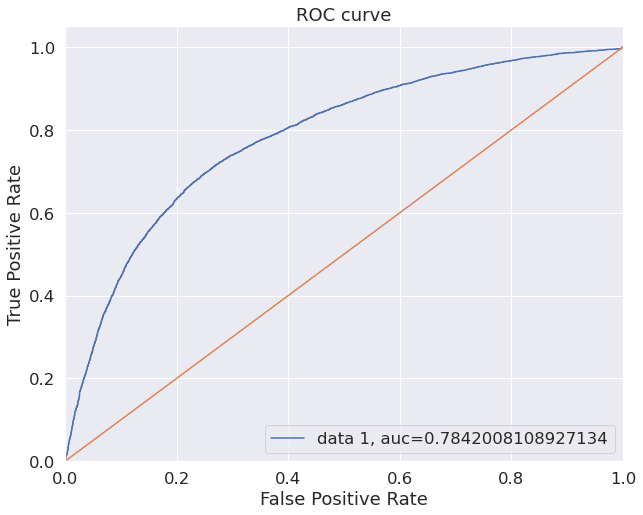

In [17]:
roc_curve(y_test, y_score)

Random forest

In [18]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42, n_jobs=-1)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.773037474423378+-0.007978794275236706


In [19]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

RandomForestClassifier = roc_auc_score(y_test, y_score)

result.append({"method":"RandomForest","roc_auc" : RandomForestClassifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.361667, F-Score=0.718, Precision=0.652, Recall=0.799


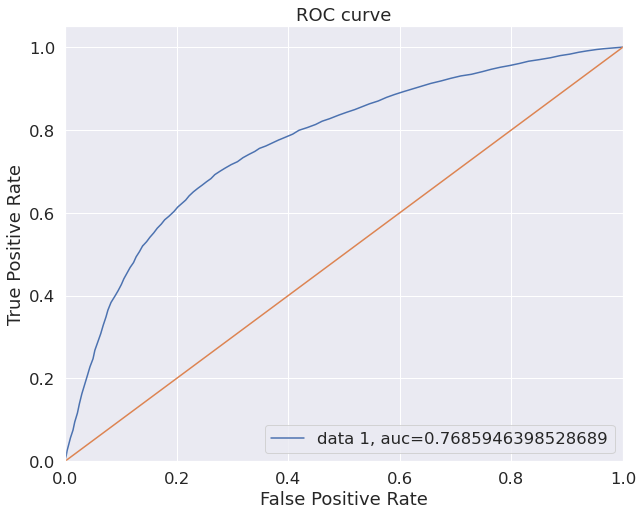

In [20]:
roc_curve(y_test, y_score)

XGboost

In [21]:
model = xgb.XGBClassifier(random_state = 42)


#запустим кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)[:, 1]

[13:45:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [22]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

XGBoost_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"XGboost","roc_auc" : XGBoost_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std
              })

Best Threshold=0.334642, F-Score=0.738, Precision=0.657, Recall=0.841


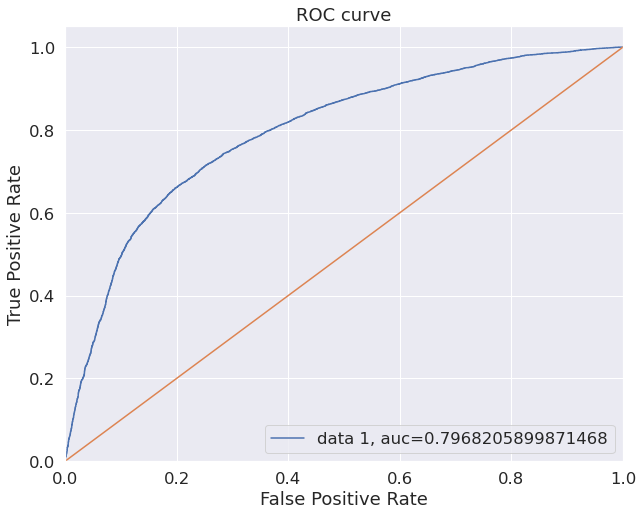

In [23]:
roc_curve(y_test, y_score)

lightgbm

In [24]:
model = lgb.LGBMClassifier(random_state = 42)


#запустим кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)[:, 1]

CV score is 0.8023594291755733+-0.00721297128565669


In [25]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Lgbm_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"Lgbm","roc_auc" : Lgbm_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.361977, F-Score=0.739, Precision=0.671, Recall=0.823


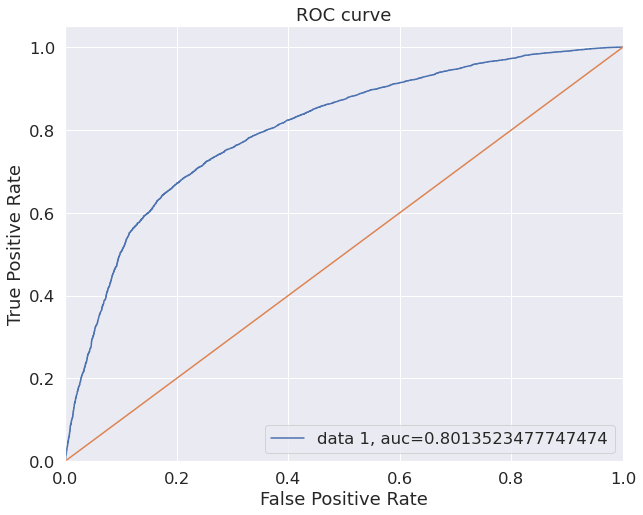

In [26]:
roc_curve(y_test, y_score)

Catboost

In [27]:
model = catb.CatBoostClassifier(silent= True ,random_state = 42)


#запустим кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)[:, 1]

CV score is 0.8022930967178368+-0.007177793794664645


In [28]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Catb_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"Catboost","roc_auc" : Catb_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.389076, F-Score=0.738, Precision=0.693, Recall=0.790


#### 2. Сравнение моделей

In [39]:
pd.DataFrame(result).sort_values('cv_score')

,method,roc_auc,fscore,precision,recall,cv_score,cv_score_std
1,RandomForest,0.768595,0.718294,0.652190,0.799309,0.773037,0.007979
0,log_reg,0.784201,0.730375,0.647101,0.838249,0.786947,0.008450
2,XGboost,0.796821,0.737677,0.656745,0.841359,0.798315,0.006489
4,Catboost,0.801243,0.738162,0.692548,0.790207,0.802293,0.007178
3,Lgbm,0.801352,0.739151,0.670703,0.823157,0.802359,0.007213


Я считаю что Catboost лучше справляется с задачей, потому что у модели самый высокий precision а это говорит о том что модель лучше других классифицирует целевую переменную, имеет самые большие roc_auc и fscore. 

### 5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого)

roc_auc_curve больше подходит, в случаее с precision_recall_curve необходимо проволить балансировку классов, или добавлять вес малочисленному классу 